In [24]:
import tensorflow as tf
import math
import numpy as np
import matplotlib.pyplot as plt
import pickle
import sklearn.metrics as metrics

%matplotlib inline

In [26]:
### Load Data


# Load Training Data
training_data = np.load("Train_Set.npy")
dev_data = np.load("Dev_Set.npy")

# Separate data into features and labels
num_feats = training_data.shape[1]
training_feats = training_data[:, 0:num_feats-1]
training_labels = training_data[:, num_feats-1]
training_labels = np.reshape(training_labels, (training_labels.shape[0],1))
dev_feats = dev_data[:, 0:num_feats-1]
dev_labels = dev_data[:, num_feats-1]
dev_labels = np.reshape(dev_labels, (dev_labels.shape[0],1))

#Normalize the features 

X_train = ( training_feats - training_feats.mean(0)) / (training_feats.std(0) + 1e-8)
X_dev = ( dev_feats - dev_feats.mean(0)) / (dev_feats.std(0) + 1e-8)
print(X_train.shape)
print(X_dev.shape)

# Apply pos_ex_const to training examples
Y_train = training_labels
Y_dev = dev_labels
num_classes = 2
class_distribution = [1.0 * np.sum(Y_train == i) / Y_train.shape[0] for i in range(num_classes)]
val_class_distribution = [1.0 * np.sum(Y_dev == i) / Y_dev.shape[0] for i in range(num_classes)]
print "Train class distribution", class_distribution
print "Val class distribution", val_class_distribution

print "Train size", Y_train.shape[0] 
print "Dev size", Y_dev.shape[0] 

(60816, 370)
(7602, 370)
Train class distribution [0.9599940805051302, 0.04000591949486977]
Val class distribution [0.9605367008681925, 0.03946329913180742]
Train size 60816
Dev size 7602


In [27]:
def one_hot_matrix(labels, C):
    """
    Creates a matrix where the i-th row corresponds to the ith class number and the jth column
                     corresponds to the jth training example. So if example j had a label i. Then entry (i,j) 
                     will be 1. 
                     
    Arguments:
    labels -- vector containing the labels 
    C -- number of classes, the depth of the one hot dimension
    
    Returns: 
    one_hot -- one hot matrix
    """
    
    ### START CODE HERE ###
    
    # Create a tf.constant equal to C (depth), name it 'C'. (approx. 1 line)
    C = tf.constant(C, name="C")
    
    # Use tf.one_hot, be careful with the axis (approx. 1 line)
    one_hot_matrix = tf.one_hot(labels, depth=C, axis=0)
    
    # Create the session (approx. 1 line)
    sess = tf.Session()
    
    # Run the session (approx. 1 line)
    one_hot = sess.run(one_hot_matrix)
    
    # Close the session (approx. 1 line). See method 1 above.
    sess.close()
    
    ### END CODE HERE ###
    
    return one_hot

In [28]:
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of an image vector (num_px * num_px = 64 * 64 * 3 = 12288)
    n_y -- scalar, number of classes (from 0 to 5, so -> 6)
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
    
    Tips:
    - You will use None because it let's us be flexible on the number of examples you will for the placeholders.
      In fact, the number of examples during test/train is different.
    """

    ### START CODE HERE ### (approx. 2 lines)
    X = tf.placeholder(tf.float32, [None, n_x], name="X")
    Y = tf.placeholder(tf.float32, [None, n_y], name="Y")
    ### END CODE HERE ###
    
    return X, Y

In [29]:
def initialize_parameters(seed=42):
    parameters = {}
    parameters['W1'] = tf.get_variable("W1", [50,370], initializer = tf.contrib.layers.xavier_initializer(seed = seed))
    parameters['b1'] = tf.get_variable("b1", [50,1], initializer = tf.zeros_initializer())
    parameters['W2'] = tf.get_variable("W2", [25,50], initializer = tf.contrib.layers.xavier_initializer(seed = seed))
    parameters['b2'] = tf.get_variable("b2", [25,1], initializer = tf.zeros_initializer())
    parameters['W3'] = tf.get_variable("W3", [12,25], initializer = tf.contrib.layers.xavier_initializer(seed = seed))
    parameters['b3'] = tf.get_variable("b3", [12,1], initializer = tf.zeros_initializer())
    parameters['W4'] = tf.get_variable("W4", [6,12], initializer = tf.contrib.layers.xavier_initializer(seed = seed))
    parameters['b4'] = tf.get_variable("b4", [6,1], initializer = tf.zeros_initializer())
    parameters['W5'] = tf.get_variable("W5", [3,6], initializer = tf.contrib.layers.xavier_initializer(seed = seed))
    parameters['b5'] = tf.get_variable("b5", [3,1], initializer = tf.zeros_initializer()) 
    parameters['W6'] = tf.get_variable("W6", [1,3], initializer = tf.contrib.layers.xavier_initializer(seed = seed))
    parameters['b6'] = tf.get_variable("b6", [1,1], initializer = tf.zeros_initializer()) 
    return parameters

In [30]:
def forward_propagation(X, parameters):
    Z1 = tf.add(tf.matmul(parameters['W1'], X), parameters['b1'])       # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.tanh(Z1)                 # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(parameters['W2'], A1), parameters['b2'])  # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.tanh(Z2)                 # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(parameters['W3'], A2), parameters['b3'])  # Z3 = np.dot(W3,Z2) + b3
    A3 = tf.nn.tanh(Z3)
    Z4 = tf.add(tf.matmul(parameters['W4'], A3), parameters['b4'])
    A4 = tf.nn.tanh(Z4)
    Z5 = tf.add(tf.matmul(parameters['W5'], A4), parameters['b5'])
    A5 = tf.nn.tanh(Z5)
    Z6 = tf.add(tf.matmul(parameters['W6'], A5), parameters['b6'])
    return Z6

In [31]:
# Before reduce mean need to multiply labels by whatever weighting factor we want
# same effect as having more 1 examples

def compute_cost(Z_final, Y, wt):
#     logits = tf.transpose(Z_final)
#     labels = tf.transpose(Y)
    cost = tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(targets = Y, logits = Z_final, pos_weight = wt))
#     cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = labels, logits = tf.transpose(Z_final)))

    return cost

In [32]:
def forward_propogation_variable_layers(X, parameters, layers=[370, 50, 25, 12, 6, 1], seed=42):
    cache = {"A0":X}
    for l in range(1,len(layers)):
        w = "W" + str(l)
        b = "b" + str(l)
        z = "Z" + str(l)
        a = "A" + str(l)
        parameters[w] = tf.get_variable(w, [layers[l-1], layers[l]], initializer = tf.contrib.layers.xavier_initializer(seed = seed))
        parameters[b] = tf.get_variable(b, [ layers[l]], initializer = tf.zeros_initializer())
            
        cache[z] = tf.add(tf.matmul(cache["A" + str(l-1)], parameters[w]), parameters[b])       # Z1 = np.dot(W1, X) + b1
        if l != len(layers) -1:
            cache[a] = tf.nn.tanh(cache[z])                 # A1 = relu(Z1)
            
        scores = cache[z]
   

    return scores 

In [33]:
def random_minibatches(X_train, Y_train, minibatch_size, num_minibatches, seed):
#     np.random.seed(seed)
    m = X_train.shape[0]
    indices = np.arange(X_train.shape[1])
    np.random.shuffle(indices)
    
    result = []
    for idx in range(num_minibatches):
        indices = np.random.randint(0, m, minibatch_size)
        batch_X = X_train[indices,:]
        batch_Y = Y_train[indices,:]
        result.append((batch_X, batch_Y))
    return result

In [34]:
def add_metrics(y_true, y_pred):
#     y_pred = tf.round(tf.sigmoid(tf.transpose(z_scores)))
    prec, prec_op = tf.metrics.precision(labels=y_true,  
                                  predictions=y_pred)
    rec, rec_op = tf.metrics.recall(labels=y_true,  
                                  predictions=y_pred)
    auc, auc_op = tf.metrics.auc(labels=y_true,  
                                  predictions=y_pred)
    acc, acc_op = tf.metrics.accuracy(labels=y_true,  
                                  predictions=y_pred)
    return prec_op, rec_op, auc_op, acc_op
    

In [52]:
import collections
def model(X_train, Y_train, X_dev, Y_dev, learning_rate = 0.0001,
          num_epochs = 100, minibatch_size = 32, print_cost = True, pos_weight = 1, layers=None, seed = 12345):

    X, Y = create_placeholders(X_train.shape[1], Y_train.shape[1])
    m = X_train.shape[0]
    

    if layers == None:
        print("Using Standard Model")
#         parameters = initialize_parameters(seed)
#         Z_final = forward_propagation(X, parameters)
        parameters = {}
        Z_final = forward_propogation_variable_layers(X, parameters, seed=seed)
    else:
        print("Using Modified Layer Model")
        parameters = {}
        Z_final = forward_propogation_variable_layers(X, parameters, layers, seed)
    
    probs = tf.sigmoid(Z_final)
    y_pred = tf.round(probs)
    
    cost = compute_cost(Z_final, Y, pos_weight)
    
    prec_op, rec_op, auc_op, acc_op = add_metrics(Y, y_pred)
    
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)

    init = tf.global_variables_initializer()
    init_l = tf.local_variables_initializer()
    

    costs, precision, recall, auc, acc, dev_costs = [], [], [], [], [], []
    history = collections.defaultdict(list)
    with tf.Session() as sess:
        sess.run(init)
        sess.run(init_l)

        for epoch in range(num_epochs):
            if epoch % 10:
                print "At epoch", epoch
            epoch_cost = 0.                       # Defines a cost related to an epoch
            prec_batch = 0.
            rec_batch = 0.
            auc_batch = 0.
            acc_batch = 0.
            
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_minibatches(X_train, Y_train, minibatch_size, num_minibatches, seed)
            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _ , minibatch_cost, prec_m, rec_m, auc_m, acc_m = sess.run([optimizer, cost, prec_op, rec_op, auc_op, acc_op], feed_dict={X: minibatch_X, Y: minibatch_Y})

                
                epoch_cost += minibatch_cost / num_minibatches
                prec_batch += prec_m / num_minibatches
                rec_batch += rec_m / num_minibatches
                auc_batch += auc_m / num_minibatches
                acc_batch += acc_m / num_minibatches
                
            history["costs"].append(epoch_cost)
            history["precision"].append(prec_batch)
            history["recall"].append(rec_batch)
            history["auc"].append(auc_batch)
            history["acc"].append(acc_batch)
        
            dev_feed_dict = {X: X_dev, Y: Y_dev}
            dev_scores, dev_cost, prec_v, rec_v, auc_v, acc_v  = sess.run([Z_final, cost, prec_op, rec_op, auc_op, acc_op], dev_feed_dict) # Z_final.eval( {X: X_dev, Y: Y_dev})
#             dev_preds = 1 / (1 + np.exp(-dev_scores))
            history["dev_costs"].append(dev_cost)
            history["dev_precision"].append(prec_v)
            history["dev_recall"].append(rec_v)
            history["dev_auc"].append(auc_v)
            history["dev_acc"].append(acc_v)
#             dev_predictions = sess.run(y_pred, dev_feed_dict)
#             print(dev_predictions)
            
        parameters = sess.run(parameters)
        
#         history = { "costs":costs, "precision": precision, "recall":recall, "auc": auc, "acc": acc, "dev_costs":dev_costs}
        
#         print ("Train Accuracy:", acc_batch)
        print ("Test Accuracy:", str(history["acc"][-1]))
        
#         dev_predictions =
        return parameters, history, dev_scores

In [59]:
tf.reset_default_graph()





# 5 appears to be the optimal weighting

num_epochs=40
import time
s = time.time()
parameters, history, dev_scores = model(X_train, Y_train, X_dev, Y_dev, pos_weight = 5, num_epochs=100, layers=[370, 400,1000,500,100,1])
# print(dev_predictions)
e = time.time()
print "average time per epoch", (e - s) / num_epochs

with open("single_model_history.pkl", "wb") as single_model_history_file:
    pickle.dump(history, single_model_history_file)


Using Modified Layer Model
At epoch 1
At epoch 2
At epoch 3
At epoch 4
At epoch 5
At epoch 6
At epoch 7
At epoch 8
At epoch 9
At epoch 11
At epoch 12
At epoch 13
At epoch 14
At epoch 15
At epoch 16
At epoch 17
At epoch 18
At epoch 19
At epoch 21
At epoch 22
At epoch 23
At epoch 24
At epoch 25
At epoch 26
At epoch 27
At epoch 28
At epoch 29
At epoch 31
At epoch 32
At epoch 33
At epoch 34
At epoch 35
At epoch 36
At epoch 37
At epoch 38
At epoch 39
At epoch 41
At epoch 42
At epoch 43
At epoch 44
At epoch 45
At epoch 46
At epoch 47
At epoch 48
At epoch 49
At epoch 51
At epoch 52
At epoch 53
At epoch 54
At epoch 55
At epoch 56
At epoch 57
At epoch 58
At epoch 59
At epoch 61
At epoch 62
At epoch 63
At epoch 64
At epoch 65
At epoch 66
At epoch 67
At epoch 68
At epoch 69
At epoch 71
At epoch 72
At epoch 73
At epoch 74
At epoch 75
At epoch 76
At epoch 77
At epoch 78
At epoch 79
At epoch 81
At epoch 82
At epoch 83
At epoch 84
At epoch 85
At epoch 86
At epoch 87
At epoch 88
At epoch 89
At epoch 9

[0.21069713815460137, 0.1893721909658989, 0.21362295859730127, 0.19932611766978178, 0.24661118970141702, 0.20169009005006353, 0.2021883783041452, 0.22058965351383986, 0.21171725060290875, 0.20276582289944514, 0.19895574952300782, 0.20425520295566085, 0.1983194605589188, 0.19534250385972915, 0.20427383396963228, 0.20868422614193186, 0.20414860863082143, 0.19213609590595773, 0.1995568535721967, 0.20246736385906647, 0.2132665376005534, 0.20004067341418535, 0.2038666648722385, 0.2186425664074925, 0.1907440120207049, 0.18805769384304644, 0.20533819744452778, 0.1984593380498165, 0.20711819543689722, 0.20213211954112648, 0.20485994504772706, 0.20799727071494323, 0.18709262944606936, 0.21646843329862295, 0.2081518522984057, 0.23741397836919292, 0.20149086479507444, 0.21448687369359792, 0.20881631162116857, 0.21276320949336103, 0.23105549846367057, 0.21217619283806383, 0.21756902126088715, 0.21503573149366656, 0.210463347933323, 0.19856876938331974, 0.21067854047451715, 0.22580958188869882, 0.2

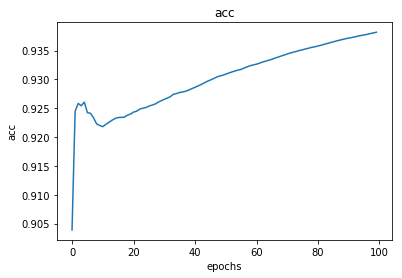

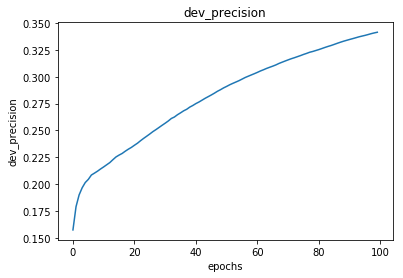

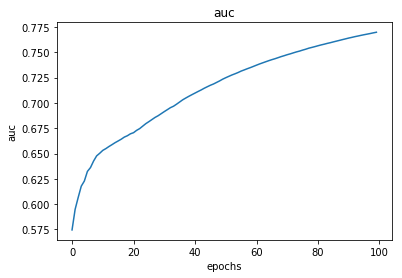

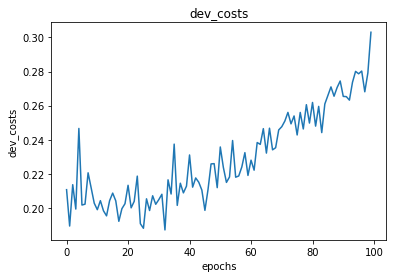

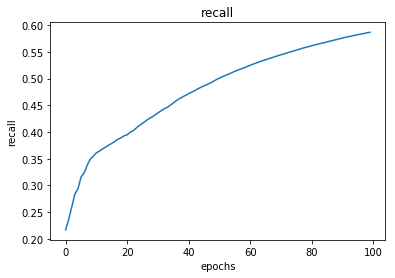

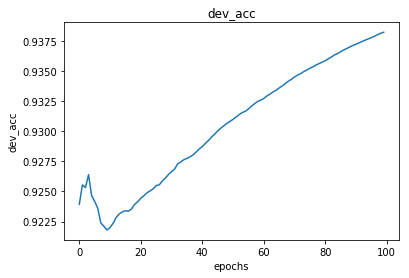

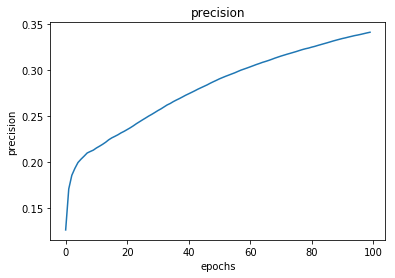

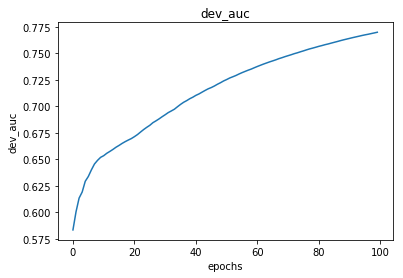

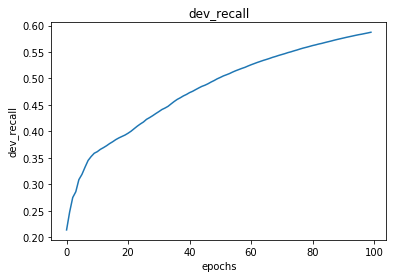

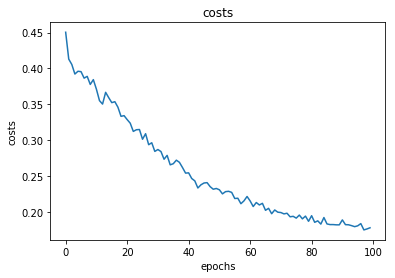

In [62]:
###Plot History

def plot_model(name, x, y, x_axis_name="epochs", y_axis_name="cost"):
        plt.plot(x, y)
        plt.title(name)
        plt.ylabel(y_axis_name)
        plt.xlabel(x_axis_name)
        plt.savefig("single_model_" + y_axis_name + ".png")
        plt.show()
    
print(history["dev_costs"])
num_epochs = len(history["costs"])
for key in history:
    plot_model(key, range(num_epochs), history[key], y_axis_name=key)
# plot_model("precision", range(num_epochs), history["precision"], y_axis_name="precision")
# plot_model("recall", range(num_epochs), history["recall"], y_axis_name="recall")
# plot_model("auc", range(num_epochs), history["auc"], y_axis_name="auc")
# plot_model("dev_loss", range(num_epochs), history["dev_costs"], y_axis_name="cost")
# plot_model("acc", range(num_epochs), history["acc"], y_axis_name="acc")

In [63]:
### Tuning Number of Layers

layers = [
    [370, 1],
    [370, 150, 1],
    [370, 150, 100, 1],
    [370, 150, 100, 50, 1],
    [370, 150, 100, 50, 20,  1],
    [370, 150, 100, 50, 20, 5, 1],
#     [370, 200, 150, 100, 50, 20, 5, 1],
    [370, 400,1000,500,100,1],
    [370, 400,300, 200, 150, 100, 50, 20, 5, 1],

]

model_names = ["layers_" + "_".join([str(x) for x in layer]) for layer in layers]
model_names = ["layers_" + "_" + str(len(layer)) for layer in layers]

histories = []
for layer in layers:
    tf.reset_default_graph()

    parameters, history, dev_predictions = model(X_train, Y_train, X_dev, Y_dev, pos_weight = 5, num_epochs=100, layers=layer)
    histories.append(history)


with open("layers_history.pkl", "wb") as layer_history_file:
    pickle.dump(histories, layer_history_file)
    

        

Using Modified Layer Model
At epoch 1
At epoch 2


/home/linus/.conda/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp


At epoch 3
At epoch 4
At epoch 5
At epoch 6
At epoch 7
At epoch 8
At epoch 9
At epoch 11
At epoch 12
At epoch 13
At epoch 14
At epoch 15
At epoch 16
At epoch 17
At epoch 18
At epoch 19
At epoch 21
At epoch 22
At epoch 23
At epoch 24
At epoch 25
At epoch 26
At epoch 27
At epoch 28
At epoch 29
At epoch 31
At epoch 32
At epoch 33
At epoch 34
At epoch 35
At epoch 36
At epoch 37
At epoch 38
At epoch 39
At epoch 41
At epoch 42
At epoch 43
At epoch 44
At epoch 45
At epoch 46
At epoch 47
At epoch 48
At epoch 49
At epoch 51
At epoch 52
At epoch 53
At epoch 54
At epoch 55
At epoch 56
At epoch 57
At epoch 58
At epoch 59
At epoch 61
At epoch 62
At epoch 63
At epoch 64
At epoch 65
At epoch 66
At epoch 67
At epoch 68
At epoch 69
At epoch 71
At epoch 72
At epoch 73
At epoch 74
At epoch 75
At epoch 76
At epoch 77
At epoch 78
At epoch 79
At epoch 81
At epoch 82
At epoch 83
At epoch 84
At epoch 85
At epoch 86
At epoch 87
At epoch 88
At epoch 89
At epoch 91
At epoch 92
At epoch 93
At epoch 94
At epoch 95

At epoch 24
At epoch 25
At epoch 26
At epoch 27
At epoch 28
At epoch 29
At epoch 31
At epoch 32
At epoch 33
At epoch 34
At epoch 35
At epoch 36
At epoch 37
At epoch 38
At epoch 39
At epoch 41
At epoch 42
At epoch 43
At epoch 44
At epoch 45
At epoch 46
At epoch 47
At epoch 48
At epoch 49
At epoch 51
At epoch 52
At epoch 53
At epoch 54
At epoch 55
At epoch 56
At epoch 57
At epoch 58
At epoch 59
At epoch 61
At epoch 62
At epoch 63
At epoch 64
At epoch 65
At epoch 66
At epoch 67
At epoch 68
At epoch 69
At epoch 71
At epoch 72
At epoch 73
At epoch 74
At epoch 75
At epoch 76
At epoch 77
At epoch 78
At epoch 79
At epoch 81
At epoch 82
At epoch 83
At epoch 84
At epoch 85
At epoch 86
At epoch 87
At epoch 88
At epoch 89
At epoch 91
At epoch 92
At epoch 93
At epoch 94
At epoch 95
At epoch 96
At epoch 97
At epoch 98
At epoch 99
('Test Accuracy:', '0.9318470462058736')


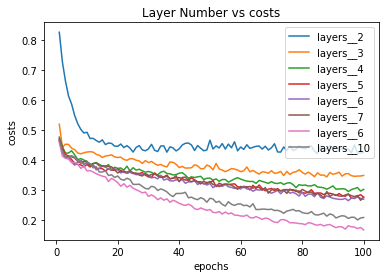

best table for metric: costs
('num_epochs = ', 100)
layers__2 , 0.4218978652554117
layers__3 , 0.34472661729117726
layers__4 , 0.29605935425742674
layers__5 , 0.27287020918079896
layers__6 , 0.2657717820433413
layers__7 , 0.2668292722988284
layers__6 , 0.16850311346744262
layers__10 , 0.20182570303496208


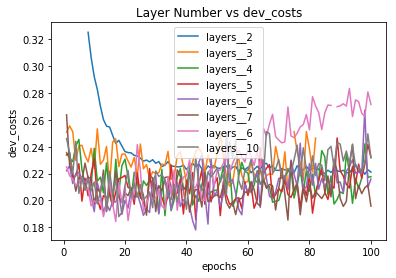

best table for metric: dev_costs
('num_epochs = ', 100)
layers__2 , 0.21913886376452169
layers__3 , 0.2080765261178435
layers__4 , 0.1886457124785968
layers__5 , 0.1858684866677702
layers__6 , 0.17808632421325352
layers__7 , 0.18542495655617242
layers__6 , 0.18433990673181125
layers__10 , 0.1880049609650937


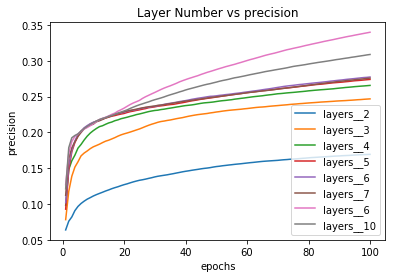

best table for metric: precision
('num_epochs = ', 100)
layers__2 , 0.16934607958323053
layers__3 , 0.24672041562042768
layers__4 , 0.26550433047507943
layers__5 , 0.2738573724031448
layers__6 , 0.27723592897779054
layers__7 , 0.27567597354713186
layers__6 , 0.3396638904119791
layers__10 , 0.3086489962119807


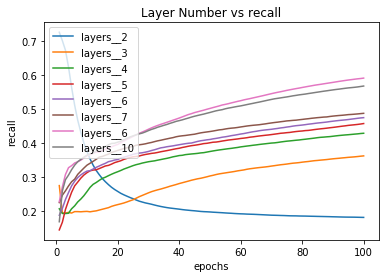

best table for metric: recall
('num_epochs = ', 100)
layers__2 , 0.7265628143047027
layers__3 , 0.36330008042486084
layers__4 , 0.4297678013224354
layers__5 , 0.45832018671851377
layers__6 , 0.47563212476278666
layers__7 , 0.4883306593173429
layers__6 , 0.5918121056807663
layers__10 , 0.568502264305166


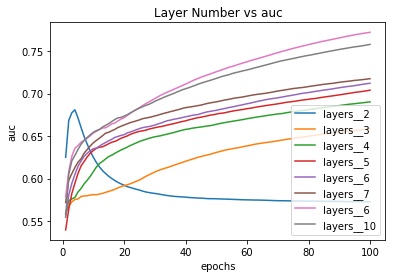

best table for metric: auc
('num_epochs = ', 100)
layers__2 , 0.6808429128245306
layers__3 , 0.6585922615779064
layers__4 , 0.6901457163534667
layers__5 , 0.7039320315499048
layers__6 , 0.7120063495949697
layers__7 , 0.7174142925362839
layers__6 , 0.7720251944190596
layers__10 , 0.7577393562229043


In [64]:
def plot_models(model_names, x, Y, x_axis_name="epochs", metric="cost"):
    for y in range(len(Y)):
        plt.plot(x, Y[y][metric])
    plt.title("Layer Number vs " + metric)
    plt.legend(model_names)
    plt.ylabel(metric)
    plt.xlabel(x_axis_name)
    plt.savefig("layers_" + metric + ".png")
    plt.show()

x = range(1,len(histories[0]["costs"])+1)
for metric in ["costs", "dev_costs"]:
    plot_models(model_names, x, histories, metric=metric)
    
    print("best table for metric: " + metric)
    print("num_epochs = ", len(x))
    for i in range(len(histories)):
        model_name = model_names[i]
        history = histories[i]
        print model_name, ",", str(np.min(history[metric]))
        
for metric in [ "precision", "recall", "auc"]:
    plot_models(model_names, x, histories, metric=metric)
    
    print("best table for metric: " + metric)
    print("num_epochs = ", len(x))
    for i in range(len(histories)):
        model_name = model_names[i]
        history = histories[i]
        print model_name, ",",  str(np.max(history[metric]))

In [44]:
### Model Ensemble
MAX_ENSEMBLE_SIZE = 30

dev_predictions = []

dev_average = None
losses = []
aucs = []

for i in range(MAX_ENSEMBLE_SIZE):
    tf.reset_default_graph()

    parameters, history, scores = model(X_train, Y_train, X_dev, Y_dev, pos_weight = 5, num_epochs=100, layers=[370, 400,1000,500,100,1], seed=np.random.randint(1, 1e8))
    dev_preds = 1 / (1 + np.exp(-scores))
    if i == 0:
        dev_average = dev_preds
    else:
        dev_average = (dev_average * i + dev_preds)  / (i + 1)  # Update the average
    # Add any other metrics here
    # For instance for accuracy use metrics.accuracy
    loss = metrics.log_loss(Y_dev, dev_average)
    auc = metrics.roc_auc_score(Y_dev, dev_average)
    
    dev_predictions.append(dev_preds)
    losses.append(loss)
    aucs.append(auc)




Using Modified Layer Model
At epoch 1
At epoch 2
At epoch 3
At epoch 4
At epoch 5
At epoch 6
At epoch 7
At epoch 8
At epoch 9
At epoch 11
At epoch 12
At epoch 13
At epoch 14
At epoch 15
At epoch 16
At epoch 17
At epoch 18
At epoch 19
At epoch 21
At epoch 22
At epoch 23
At epoch 24
At epoch 25
At epoch 26
At epoch 27
At epoch 28
At epoch 29
At epoch 31
At epoch 32
At epoch 33
At epoch 34
At epoch 35
At epoch 36
At epoch 37
At epoch 38
At epoch 39
At epoch 41
At epoch 42
At epoch 43
At epoch 44
At epoch 45
At epoch 46
At epoch 47
At epoch 48
At epoch 49
At epoch 51
At epoch 52
At epoch 53
At epoch 54
At epoch 55
At epoch 56
At epoch 57
At epoch 58
At epoch 59
At epoch 61
At epoch 62
At epoch 63
At epoch 64
At epoch 65
At epoch 66
At epoch 67
At epoch 68
At epoch 69
At epoch 71
At epoch 72
At epoch 73
At epoch 74
At epoch 75
At epoch 76
At epoch 77
At epoch 78
At epoch 79
At epoch 81
At epoch 82
At epoch 83
At epoch 84
At epoch 85
At epoch 86
At epoch 87
At epoch 88
At epoch 89
At epoch 9

At epoch 19
At epoch 21
At epoch 22
At epoch 23
At epoch 24
At epoch 25
At epoch 26
At epoch 27
At epoch 28
At epoch 29
At epoch 31
At epoch 32
At epoch 33
At epoch 34
At epoch 35
At epoch 36
At epoch 37
At epoch 38
At epoch 39
At epoch 41
At epoch 42
At epoch 43
At epoch 44
At epoch 45
At epoch 46
At epoch 47
At epoch 48
At epoch 49
At epoch 51
At epoch 52
At epoch 53
At epoch 54
At epoch 55
At epoch 56
At epoch 57
At epoch 58
At epoch 59
At epoch 61
At epoch 62
At epoch 63
At epoch 64
At epoch 65
At epoch 66
At epoch 67
At epoch 68
At epoch 69
At epoch 71
At epoch 72
At epoch 73
At epoch 74
At epoch 75
At epoch 76
At epoch 77
At epoch 78
At epoch 79
At epoch 81
At epoch 82
At epoch 83
At epoch 84
At epoch 85
At epoch 86
At epoch 87
At epoch 88
At epoch 89
At epoch 91
At epoch 92
At epoch 93
At epoch 94
At epoch 95
At epoch 96
At epoch 97
At epoch 98
At epoch 99
('Test Accuracy:', '0.9379035987665759')
Using Modified Layer Model
At epoch 1
At epoch 2
At epoch 3
At epoch 4
At epoch 5
A

At epoch 41
At epoch 42
At epoch 43
At epoch 44
At epoch 45
At epoch 46
At epoch 47
At epoch 48
At epoch 49
At epoch 51
At epoch 52
At epoch 53
At epoch 54
At epoch 55
At epoch 56
At epoch 57
At epoch 58
At epoch 59
At epoch 61
At epoch 62
At epoch 63
At epoch 64
At epoch 65
At epoch 66
At epoch 67
At epoch 68
At epoch 69
At epoch 71
At epoch 72
At epoch 73
At epoch 74
At epoch 75
At epoch 76
At epoch 77
At epoch 78
At epoch 79
At epoch 81
At epoch 82
At epoch 83
At epoch 84
At epoch 85
At epoch 86
At epoch 87
At epoch 88
At epoch 89
At epoch 91
At epoch 92
At epoch 93
At epoch 94
At epoch 95
At epoch 96
At epoch 97
At epoch 98
At epoch 99
('Test Accuracy:', '0.9384215491068972')
Using Modified Layer Model
At epoch 1
At epoch 2
At epoch 3
At epoch 4
At epoch 5
At epoch 6
At epoch 7
At epoch 8
At epoch 9
At epoch 11
At epoch 12
At epoch 13
At epoch 14
At epoch 15
At epoch 16
At epoch 17
At epoch 18
At epoch 19
At epoch 21
At epoch 22
At epoch 23
At epoch 24
At epoch 25
At epoch 26
At ep

At epoch 62
At epoch 63
At epoch 64
At epoch 65
At epoch 66
At epoch 67
At epoch 68
At epoch 69
At epoch 71
At epoch 72
At epoch 73
At epoch 74
At epoch 75
At epoch 76
At epoch 77
At epoch 78
At epoch 79
At epoch 81
At epoch 82
At epoch 83
At epoch 84
At epoch 85
At epoch 86
At epoch 87
At epoch 88
At epoch 89
At epoch 91
At epoch 92
At epoch 93
At epoch 94
At epoch 95
At epoch 96
At epoch 97
At epoch 98
At epoch 99
('Test Accuracy:', '0.9392550359274238')
Using Modified Layer Model
At epoch 1
At epoch 2
At epoch 3
At epoch 4
At epoch 5
At epoch 6
At epoch 7
At epoch 8
At epoch 9
At epoch 11
At epoch 12
At epoch 13
At epoch 14
At epoch 15
At epoch 16
At epoch 17
At epoch 18
At epoch 19
At epoch 21
At epoch 22
At epoch 23
At epoch 24
At epoch 25
At epoch 26
At epoch 27
At epoch 28
At epoch 29
At epoch 31
At epoch 32
At epoch 33
At epoch 34
At epoch 35
At epoch 36
At epoch 37
At epoch 38
At epoch 39
At epoch 41
At epoch 42
At epoch 43
At epoch 44
At epoch 45
At epoch 46
At epoch 47
At ep

At epoch 83
At epoch 84
At epoch 85
At epoch 86
At epoch 87
At epoch 88
At epoch 89
At epoch 91
At epoch 92
At epoch 93
At epoch 94
At epoch 95
At epoch 96
At epoch 97
At epoch 98
At epoch 99
('Test Accuracy:', '0.93835245810057')
Using Modified Layer Model
At epoch 1
At epoch 2
At epoch 3
At epoch 4
At epoch 5
At epoch 6
At epoch 7
At epoch 8
At epoch 9
At epoch 11
At epoch 12
At epoch 13
At epoch 14
At epoch 15
At epoch 16
At epoch 17
At epoch 18
At epoch 19
At epoch 21
At epoch 22
At epoch 23
At epoch 24
At epoch 25
At epoch 26
At epoch 27
At epoch 28
At epoch 29
At epoch 31
At epoch 32
At epoch 33
At epoch 34
At epoch 35
At epoch 36
At epoch 37
At epoch 38
At epoch 39
At epoch 41
At epoch 42
At epoch 43
At epoch 44
At epoch 45
At epoch 46
At epoch 47
At epoch 48
At epoch 49
At epoch 51
At epoch 52
At epoch 53
At epoch 54
At epoch 55
At epoch 56
At epoch 57
At epoch 58
At epoch 59
At epoch 61
At epoch 62
At epoch 63
At epoch 64
At epoch 65
At epoch 66
At epoch 67
At epoch 68
At epoc

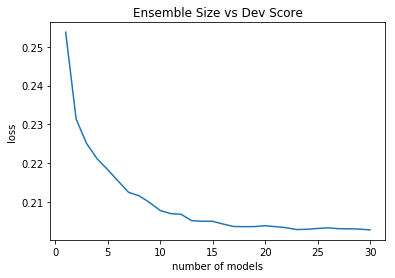

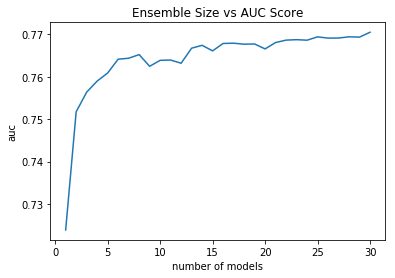

In [45]:
# Plot Results

plt.plot(range(1, MAX_ENSEMBLE_SIZE+1), losses)
plt.title("Ensemble Size vs Dev Score")
plt.ylabel("loss")
plt.xlabel("number of models")
plt.savefig("ensemble_v_loss.png")
plt.show()


plt.plot(range(1, MAX_ENSEMBLE_SIZE+1), aucs)

plt.title("Ensemble Size vs AUC Score")
plt.ylabel("auc")
plt.xlabel("number of models")
plt.savefig("ensemble_v_auc.png")

plt.show()

